In [53]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import os

In [111]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  #Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def gap_distance(self, vehicle_row_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        """vehicle row to be checked: Input is row 0, you check for lane 1(row 0 and 1). Input is row 1, you check for lane at the middle (row 1 and 2). Input is row 2, you check for lane 2(rows 2 and 3)."""
        rear_bumper_position = self.x_position
        print(f"{self.vehicle_type} {self.vehicle_id}'s rear bumper is at {rear_bumper_position}")
        front_bumper_position = rear_bumper_position + self.length - 1
        print(f"{self.vehicle_type} {self.vehicle_id}'s front bumper is at {front_bumper_position}")
        max_distance = self.speed #maximum distance checked is equivalent to speed
        print(f"{self.vehicle_type} {self.vehicle_id}'s maximum distance is  {max_distance}")
        road_length = self.road_designation.road_length
        print(f"{self.vehicle_type} {self.vehicle_id}'s road has length of {road_length}")
        
        gap_distance = max_distance
        print(f"{self.vehicle_type} {self.vehicle_id}: default gap distance is {gap_distance}")
        '''gap_distance_row_2 = max_distance
        print(f"{self.vehicle_type} {self.vehicle_id}: gap distance of left row is {gap_distance_row_2}")'''
        
        for distance in range(1, max_distance + 1):
            start_of_space_to_be_checked = (front_bumper_position + distance)  % road_length
            print(f"{self.vehicle_type} {self.vehicle_id}: At the current speed, we are checking position {start_of_space_to_be_checked} row {self.current_row} to {self.current_row + 1} ")
            end_of_space_to_be_checked = (front_bumper_position + max_distance)  % road_length #We have to include the front bumper position, to avoid vehicle overlaps
            print(f"{self.vehicle_type} {self.vehicle_id}: At the current speed, we check until position {end_of_space_to_be_checked}")
            
            # Check if there's an occupied space within the distance
            if start_of_space_to_be_checked < end_of_space_to_be_checked:
                print(f"Checking occupancy at position {start_of_space_to_be_checked} in row {vehicle_row_to_be_checked} to row {vehicle_row_to_be_checked + 1}")
                print(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    break
                    print(f" The gap distance of {self.vehicle_type} {self.vehicle_id} is {gap_distance}")
            else:  # Wrap-around case
                print(f"Checking occupancy wrap-around at position {start_of_space_to_be_checked} in row {vehicle_row_to_be_checked} to row {vehicle_row_to_be_checked + 1}")
                print(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                #print(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0: #or \
                   #np.sum(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    break
                    print(f" The gap distance of {self.vehicle_type} {self.vehicle_id} is {gap_distance}")
                    
        '''for distance in range(1, max_distance + 1):
            next_rear_bumper_position = (rear_bumper_position + distance) % road_length
            next_front_bumper_position = (front_bumper_position + distance) % road_length

            if next_rear_bumper_position < next_front_bumper_position:
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:next_front_bumper_position, vehicle_row_to_be_checked+1]) != 0:
                    gap_distance_row_2 = distance - 1
                    print(f"The gap distance on row {self.current_row + 1} is {gap_distance_row_2}.")
                    break
            else:  # Wrap-around case
                if np.sum(self.road_designation.road_occupancy[next_rear_bumper_position:, vehicle_row_to_be_checked+1]) != 0 or \
                   np.sum(self.road_designation.road_occupancy[:next_front_bumper_position, vehicle_row_to_be_checked+1]) != 0:
                    gap_distance_row_2 = distance - 1
                    print(f"The gap distance on row {self.current_row + 1} is {gap_distance_row_2}.")
                    break'''
                
        #if min(gap_distance_row_1, gap_distance_row_2) < 0: #For debugging
            #print(gap_distance_row_1, gap_distance_row_2, current_x_position) #Results to negative headway distance
        #print(min(gap_distance_row_1, gap_distance_row_2))
        return gap_distance # Return the  gap distance

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is 0 to 4 (bottom to top). Right side is the bottom."""
        new_row = self.current_row #by default, vehicle stays on its lane
        gap_distance_of_own_lane = self.gap_distance(self.current_row) #obtains the gap distance of current lane
        print(f"{self.vehicle_type}{self.vehicle_id} has a gap distance of {gap_distance_of_own_lane}")
        gap_distance_of_adjacent_right_lane = self.gap_distance(self.current_row - 1) if self.current_row > 0 else gap_distance_of_own_lane
        print(f" The right row(and its corresponding lane) of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_right_lane} cells.")
        gap_distance_of_adjacent_left_lane = self.gap_distance(self.current_row + 1) if self.current_row < 2 else gap_distance_of_own_lane
        print(f" The left row(and its corresponding lane) of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_left_lane} cells.")
        if self.speed > gap_distance_of_own_lane:
            if self.current_row == 0 and gap_distance_of_adjacent_left_lane > gap_distance_of_own_lane:#There are specific cases wherein changing to the right or left lane is possible/legal
                new_row = self.current_row + 1
                print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
            elif self.current_row == 2 and gap_distance_of_adjacent_right_lane>gap_distance_of_own_lane: 
                new_row = self.current_row - 1
                print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
            elif self.current_row == 1 and gap_distance_own_lane < max(gap_distance_of_adjacent_right_lane, gap_distance_of_adjacent_left_lane):
                if gap_distance_of_adjacent_right_lane > gap_distance_of_adjacent_left_lane:
                    new_row = self.current_row - 1
                    print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
                elif gap_distance_of_adjacent_right_lane < gap_distance_of_adjacent_left_lane:
                    new_row = self.current_row + 1
                    print(f" Vehicle {self.vehicle_id} in row {self.current_row} switches to row {new_row}")
        # Check for space on the new lane
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width].sum() == 0:
            self.current_row = new_row

        #For debugging:
        if self.speed < gap_distance_of_own_lane:
            print(vehicle.gap_distance, gap_distance_of_own_lane, vehicle.speed)
        if gap_distance_of_own_lane < 0:
            print(f"{self.vehicle_type} {vehicle.vehicle_id} invalid")

    def decelerate(self):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        gap_distance_of_own_lane = self.gap_distance(self.current_row)
        if self.speed > gap_distance_of_own_lane:
            self.speed = gap_distance_of_own_lane
            print(f"{self.vehicle_type} {self.vehicle_id} is decelerating on own lane")

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1
            print(f"{self.vehicle_type} {self.vehicle_id} is braking")


    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position

In [112]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [115]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the input agents and initializes output data"""
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        #self.vehicle_throughput = 0

    def update_occupancy(self):
        """This method updates road occupancy based on vehicle position and length"""
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #from vehicle rear bumper(position|) to front, minus 1. takes account of toroidal boundaries
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
            else:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'  # Randomly decide vehicle type
            length = 7 if vehicle_type == 'truck' else 3
            width = 2
            x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = truck_lane_change_prob if vehicle_type == 'truck' else jeep_lane_change_prob
            current_row = 2 if vehicle_type == 'truck' else 0
            if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0: # is the road portion empty?
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                self.vehicles.append(new_vehicle)  # Add vehicle to the list
                if new_vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1
                else:
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 2 # Mark vehicle position on road occupancy grid
                        
    #def record_throughput(self, vehicle):
        #self.vehicle_throughput += 1

    def simulation_step(self):
        np.random.shuffle(self.vehicles)
        for vehicle in self.vehicles:
            print(f" {vehicle.vehicle_type} {vehicle.vehicle_id} attributes")
            vehicle.accelerate()  # Accelerate the vehicle
            print(f"ACCELERATE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} want to move at a speed of {vehicle.speed}")
            if np.random.rand() < vehicle.lane_changing_prob:
                vehicle.lane_changing()  # Change lane if possible
                vehicle.decelerate() # Decelerate if necessary
            else:
                vehicle.decelerate()  # Decelerate if not changing lanes
            # Apply brakes
            vehicle.braking()    
            """if vehicle.x_position == self.road.road_length - vehicle.length: #Greatest fix: redundant +speed and -length on position and road length sides, respectively
                #print(f"Vehicle {vehicle.vehicle_id} reached end of road at position {vehicle.x_position}")
                self.record_throughput(vehicle)"""
            #self.update_occupancy()
            print(f"BEFORE MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}")
            vehicle.move()  # Move the vehicle
            print(f"AFTER MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}, with a speed of {vehicle.speed} at row {vehicle.current_row}")
            

        self.update_occupancy()  # Update the road occupancy grid
        
    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

STATIC CHECKER

 jeep 140 attributes
ACCELERATE DEBUGGER: jeep 140 want to move at a speed of 5
jeep 140's rear bumper is at 41
jeep 140's front bumper is at 43
jeep 140's maximum distance is  5
jeep 140's road has length of 100
jeep 140: default gap distance is 5
jeep 140: At the current speed, we are checking position 44 row 0 to 1 
jeep 140: At the current speed, we check until position 48
Checking occupancy at position 44 in row 0 to row 1
[0. 0.]
jeep 140: At the current speed, we are checking position 45 row 0 to 1 
jeep 140: At the current speed, we check until position 48
Checking occupancy at position 45 in row 0 to row 1
[1. 1.]
jeep 140 is decelerating on own lane
BEFORE MOVE DEBUGGER: jeep 140 is at position 41
AFTER MOVE DEBUGGER: jeep 140 is at position 42, with a speed of 1 at row 0
 jeep 133 attributes
ACCELERATE DEBUGGER: jeep 133 want to move at a speed of 5
jeep 133's rear bumper is at 92
jeep 133's front bumper is at 94
jeep 133's maximum distance is  5
jeep 133's road has length o

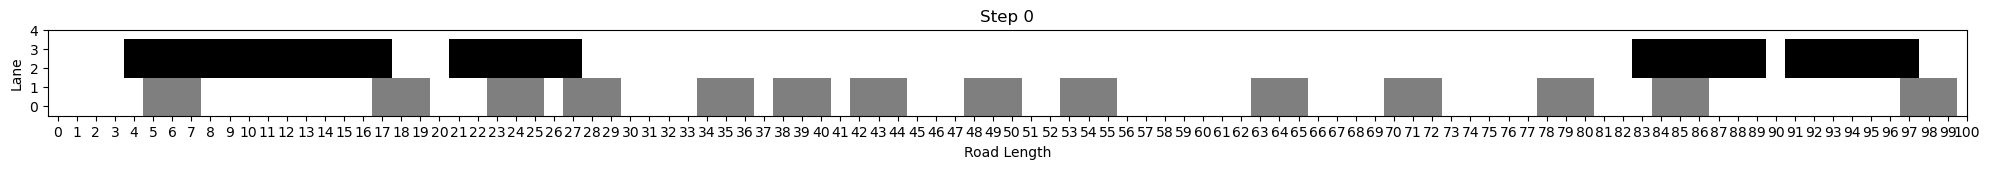

 truck 141 attributes
ACCELERATE DEBUGGER: truck 141 want to move at a speed of 3
truck 141's rear bumper is at 83
truck 141's front bumper is at 89
truck 141's maximum distance is  3
truck 141's road has length of 100
truck 141: default gap distance is 3
truck 141: At the current speed, we are checking position 90 row 2 to 3 
truck 141: At the current speed, we check until position 92
Checking occupancy at position 90 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 91 row 2 to 3 
truck 141: At the current speed, we check until position 92
Checking occupancy at position 91 in row 2 to row 3
[2. 2.]
truck 141 is decelerating on own lane
BEFORE MOVE DEBUGGER: truck 141 is at position 83
AFTER MOVE DEBUGGER: truck 141 is at position 84, with a speed of 1 at row 2
 jeep 125 attributes
ACCELERATE DEBUGGER: jeep 125 want to move at a speed of 2
jeep 125's rear bumper is at 27
jeep 125's front bumper is at 29
jeep 125's maximum distance is  2
jeep 125's roa

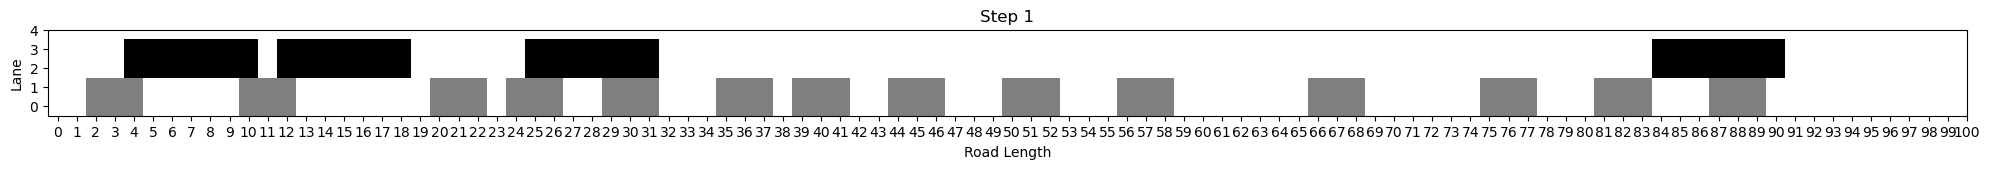

 truck 132 attributes
ACCELERATE DEBUGGER: truck 132 want to move at a speed of 1
truck 132's rear bumper is at 98
truck 132's front bumper is at 104
truck 132's maximum distance is  1
truck 132's road has length of 100
truck 132: default gap distance is 1
truck 132: At the current speed, we are checking position 5 row 2 to 3 
truck 132: At the current speed, we check until position 5
Checking occupancy wrap-around at position 5 in row 2 to row 3
[2. 2.]
truck 132 is decelerating on own lane
BEFORE MOVE DEBUGGER: truck 132 is at position 98
AFTER MOVE DEBUGGER: truck 132 is at position 98, with a speed of 0 at row 2
 jeep 125 attributes
ACCELERATE DEBUGGER: jeep 125 want to move at a speed of 3
jeep 125's rear bumper is at 29
jeep 125's front bumper is at 31
jeep 125's maximum distance is  3
jeep 125's road has length of 100
jeep 125: default gap distance is 3
jeep 125: At the current speed, we are checking position 32 row 0 to 1 
jeep 125: At the current speed, we check until position

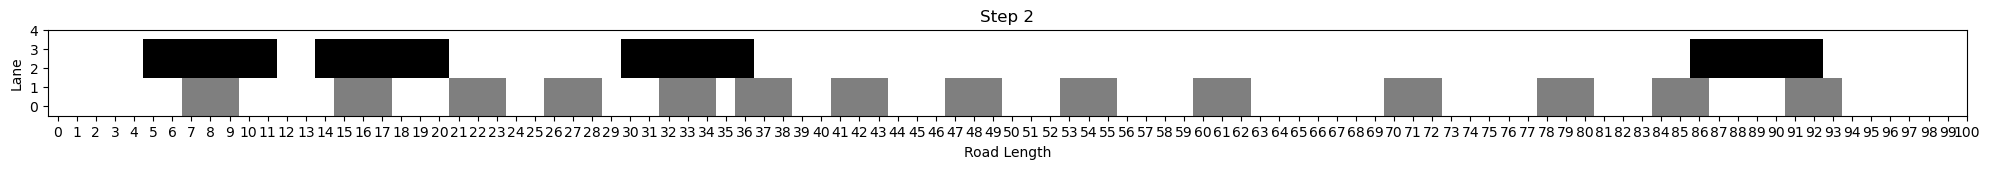

 jeep 133 attributes
ACCELERATE DEBUGGER: jeep 133 want to move at a speed of 5
jeep 133's rear bumper is at 7
jeep 133's front bumper is at 9
jeep 133's maximum distance is  5
jeep 133's road has length of 100
jeep 133: default gap distance is 5
jeep 133: At the current speed, we are checking position 10 row 0 to 1 
jeep 133: At the current speed, we check until position 14
Checking occupancy at position 10 in row 0 to row 1
[0. 0.]
jeep 133: At the current speed, we are checking position 11 row 0 to 1 
jeep 133: At the current speed, we check until position 14
Checking occupancy at position 11 in row 0 to row 1
[0. 0.]
jeep 133: At the current speed, we are checking position 12 row 0 to 1 
jeep 133: At the current speed, we check until position 14
Checking occupancy at position 12 in row 0 to row 1
[0. 0.]
jeep 133: At the current speed, we are checking position 13 row 0 to 1 
jeep 133: At the current speed, we check until position 14
Checking occupancy at position 13 in row 0 to row

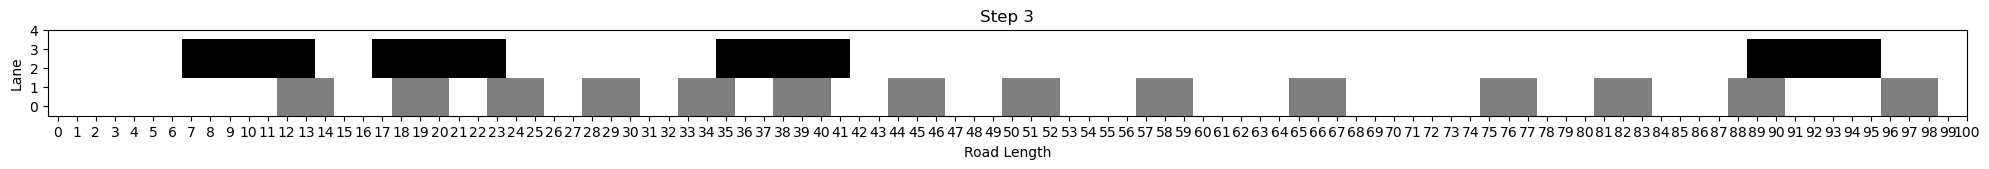

 jeep 139 attributes
ACCELERATE DEBUGGER: jeep 139 want to move at a speed of 5
jeep 139's rear bumper is at 65
jeep 139's front bumper is at 67
jeep 139's maximum distance is  5
jeep 139's road has length of 100
jeep 139: default gap distance is 5
jeep 139: At the current speed, we are checking position 68 row 0 to 1 
jeep 139: At the current speed, we check until position 72
Checking occupancy at position 68 in row 0 to row 1
[0. 0.]
jeep 139: At the current speed, we are checking position 69 row 0 to 1 
jeep 139: At the current speed, we check until position 72
Checking occupancy at position 69 in row 0 to row 1
[0. 0.]
jeep 139: At the current speed, we are checking position 70 row 0 to 1 
jeep 139: At the current speed, we check until position 72
Checking occupancy at position 70 in row 0 to row 1
[0. 0.]
jeep 139: At the current speed, we are checking position 71 row 0 to 1 
jeep 139: At the current speed, we check until position 72
Checking occupancy at position 71 in row 0 to r

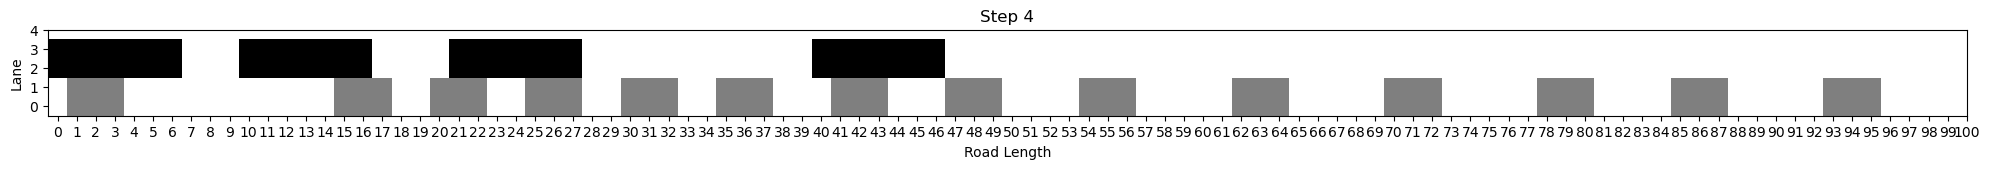

 jeep 133 attributes
ACCELERATE DEBUGGER: jeep 133 want to move at a speed of 4
jeep 133's rear bumper is at 15
jeep 133's front bumper is at 17
jeep 133's maximum distance is  4
jeep 133's road has length of 100
jeep 133: default gap distance is 4
jeep 133: At the current speed, we are checking position 18 row 0 to 1 
jeep 133: At the current speed, we check until position 21
Checking occupancy at position 18 in row 0 to row 1
[0. 0.]
jeep 133: At the current speed, we are checking position 19 row 0 to 1 
jeep 133: At the current speed, we check until position 21
Checking occupancy at position 19 in row 0 to row 1
[0. 0.]
jeep 133: At the current speed, we are checking position 20 row 0 to 1 
jeep 133: At the current speed, we check until position 21
Checking occupancy at position 20 in row 0 to row 1
[1. 1.]
jeep 133 is decelerating on own lane
BEFORE MOVE DEBUGGER: jeep 133 is at position 15
AFTER MOVE DEBUGGER: jeep 133 is at position 17, with a speed of 2 at row 0
 jeep 136 attrib

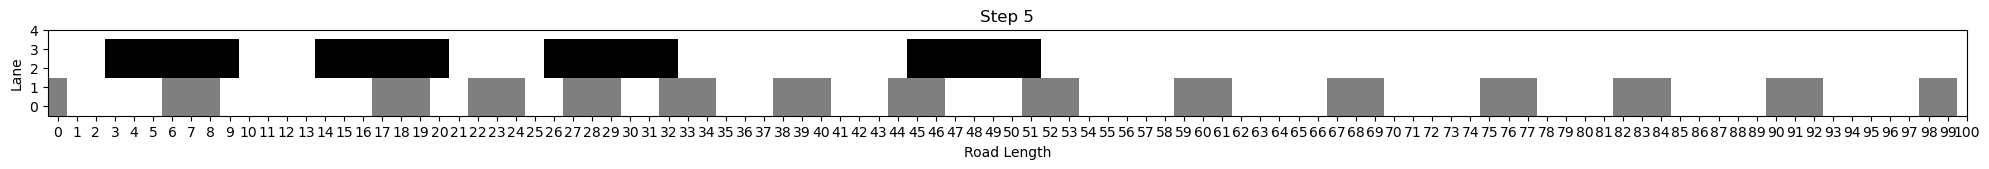

 jeep 136 attributes
ACCELERATE DEBUGGER: jeep 136 want to move at a speed of 5
jeep 136's rear bumper is at 6
jeep 136's front bumper is at 8
jeep 136's maximum distance is  5
jeep 136's road has length of 100
jeep 136: default gap distance is 5
jeep 136: At the current speed, we are checking position 9 row 0 to 1 
jeep 136: At the current speed, we check until position 13
Checking occupancy at position 9 in row 0 to row 1
[0. 0.]
jeep 136: At the current speed, we are checking position 10 row 0 to 1 
jeep 136: At the current speed, we check until position 13
Checking occupancy at position 10 in row 0 to row 1
[0. 0.]
jeep 136: At the current speed, we are checking position 11 row 0 to 1 
jeep 136: At the current speed, we check until position 13
Checking occupancy at position 11 in row 0 to row 1
[0. 0.]
jeep 136: At the current speed, we are checking position 12 row 0 to 1 
jeep 136: At the current speed, we check until position 13
Checking occupancy at position 12 in row 0 to row 1

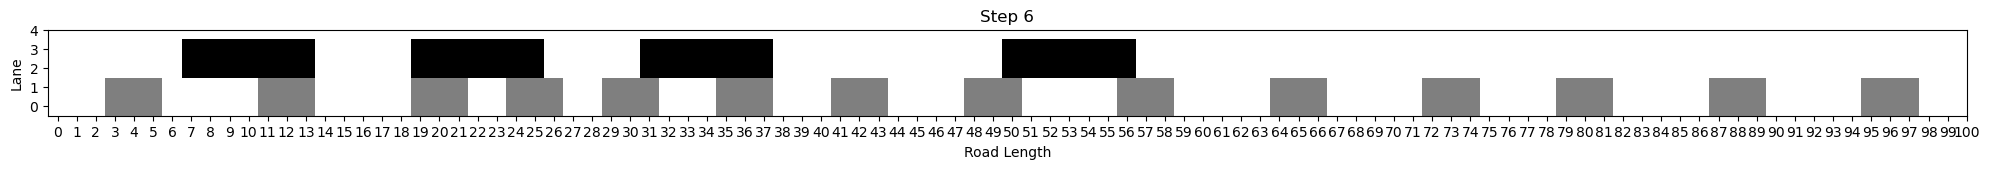

 jeep 131 attributes
ACCELERATE DEBUGGER: jeep 131 want to move at a speed of 5
jeep 131's rear bumper is at 56
jeep 131's front bumper is at 58
jeep 131's maximum distance is  5
jeep 131's road has length of 100
jeep 131: default gap distance is 5
jeep 131: At the current speed, we are checking position 59 row 0 to 1 
jeep 131: At the current speed, we check until position 63
Checking occupancy at position 59 in row 0 to row 1
[0. 0.]
jeep 131: At the current speed, we are checking position 60 row 0 to 1 
jeep 131: At the current speed, we check until position 63
Checking occupancy at position 60 in row 0 to row 1
[0. 0.]
jeep 131: At the current speed, we are checking position 61 row 0 to 1 
jeep 131: At the current speed, we check until position 63
Checking occupancy at position 61 in row 0 to row 1
[0. 0.]
jeep 131: At the current speed, we are checking position 62 row 0 to 1 
jeep 131: At the current speed, we check until position 63
Checking occupancy at position 62 in row 0 to r

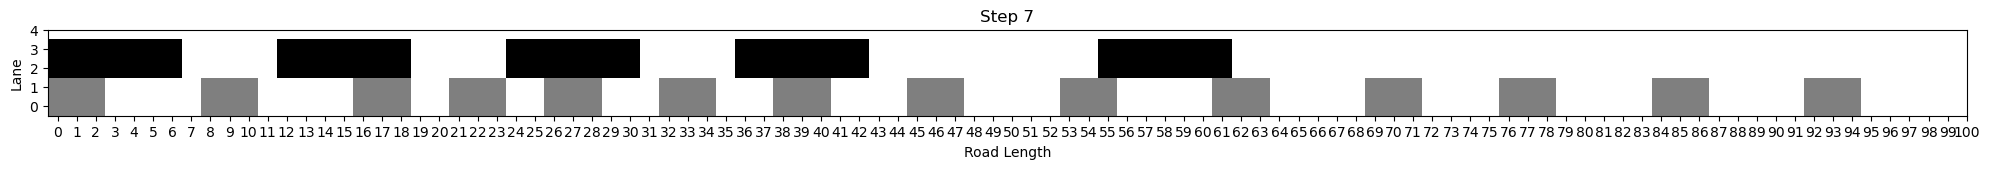

 jeep 123 attributes
ACCELERATE DEBUGGER: jeep 123 want to move at a speed of 5
jeep 123's rear bumper is at 53
jeep 123's front bumper is at 55
jeep 123's maximum distance is  5
jeep 123's road has length of 100
jeep 123: default gap distance is 5
jeep 123: At the current speed, we are checking position 56 row 0 to 1 
jeep 123: At the current speed, we check until position 60
Checking occupancy at position 56 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 57 row 0 to 1 
jeep 123: At the current speed, we check until position 60
Checking occupancy at position 57 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 58 row 0 to 1 
jeep 123: At the current speed, we check until position 60
Checking occupancy at position 58 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 59 row 0 to 1 
jeep 123: At the current speed, we check until position 60
Checking occupancy at position 59 in row 0 to r

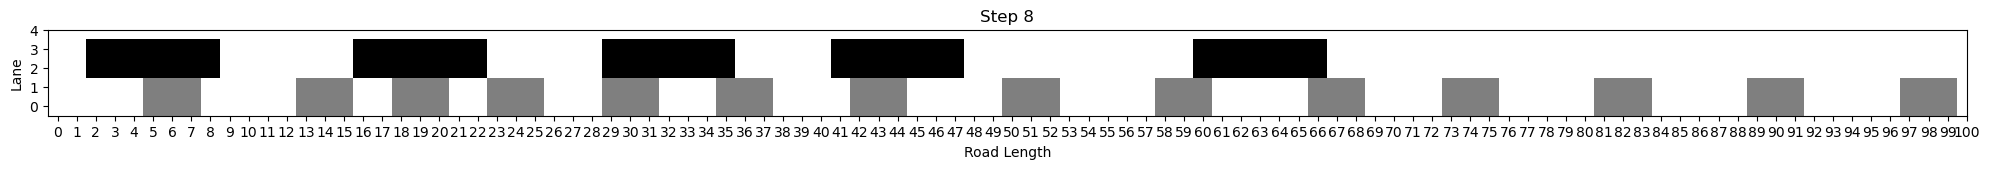

 truck 128 attributes
ACCELERATE DEBUGGER: truck 128 want to move at a speed of 5
truck 128's rear bumper is at 41
truck 128's front bumper is at 47
truck 128's maximum distance is  5
truck 128's road has length of 100
truck 128: default gap distance is 5
truck 128: At the current speed, we are checking position 48 row 2 to 3 
truck 128: At the current speed, we check until position 52
Checking occupancy at position 48 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 49 row 2 to 3 
truck 128: At the current speed, we check until position 52
Checking occupancy at position 49 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 50 row 2 to 3 
truck 128: At the current speed, we check until position 52
Checking occupancy at position 50 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 51 row 2 to 3 
truck 128: At the current speed, we check until position 52
Checking occupancy at position 5

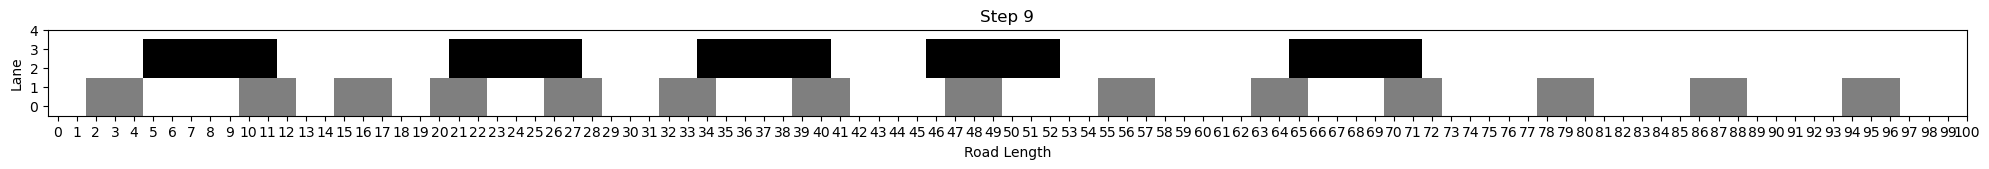

 jeep 124 attributes
ACCELERATE DEBUGGER: jeep 124 want to move at a speed of 4
jeep 124's rear bumper is at 32
jeep 124's front bumper is at 34
jeep 124's maximum distance is  4
jeep 124's road has length of 100
jeep 124: default gap distance is 4
jeep 124: At the current speed, we are checking position 35 row 0 to 1 
jeep 124: At the current speed, we check until position 38
Checking occupancy at position 35 in row 0 to row 1
[0. 0.]
jeep 124: At the current speed, we are checking position 36 row 0 to 1 
jeep 124: At the current speed, we check until position 38
Checking occupancy at position 36 in row 0 to row 1
[0. 0.]
jeep 124: At the current speed, we are checking position 37 row 0 to 1 
jeep 124: At the current speed, we check until position 38
Checking occupancy at position 37 in row 0 to row 1
[0. 0.]
jeep 124: At the current speed, we are checking position 38 row 0 to 1 
jeep 124: At the current speed, we check until position 38
Checking occupancy wrap-around at position 38 i

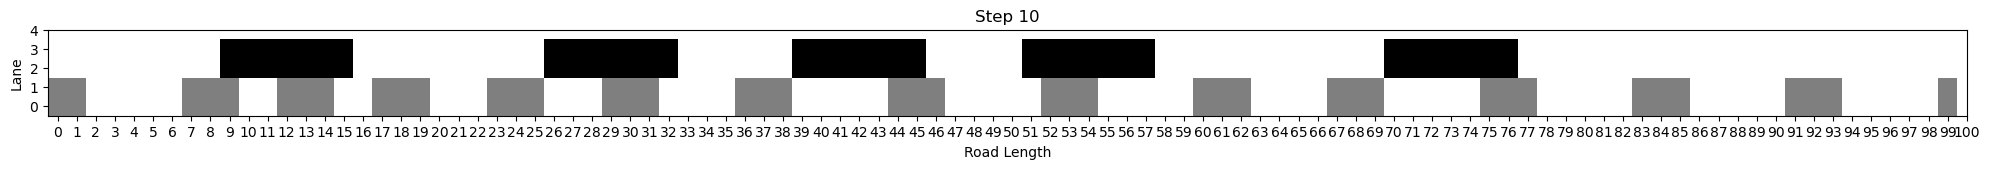

 truck 128 attributes
ACCELERATE DEBUGGER: truck 128 want to move at a speed of 5
truck 128's rear bumper is at 51
truck 128's front bumper is at 57
truck 128's maximum distance is  5
truck 128's road has length of 100
truck 128: default gap distance is 5
truck 128: At the current speed, we are checking position 58 row 2 to 3 
truck 128: At the current speed, we check until position 62
Checking occupancy at position 58 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 59 row 2 to 3 
truck 128: At the current speed, we check until position 62
Checking occupancy at position 59 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 60 row 2 to 3 
truck 128: At the current speed, we check until position 62
Checking occupancy at position 60 in row 2 to row 3
[0. 0.]
truck 128: At the current speed, we are checking position 61 row 2 to 3 
truck 128: At the current speed, we check until position 62
Checking occupancy at position 6

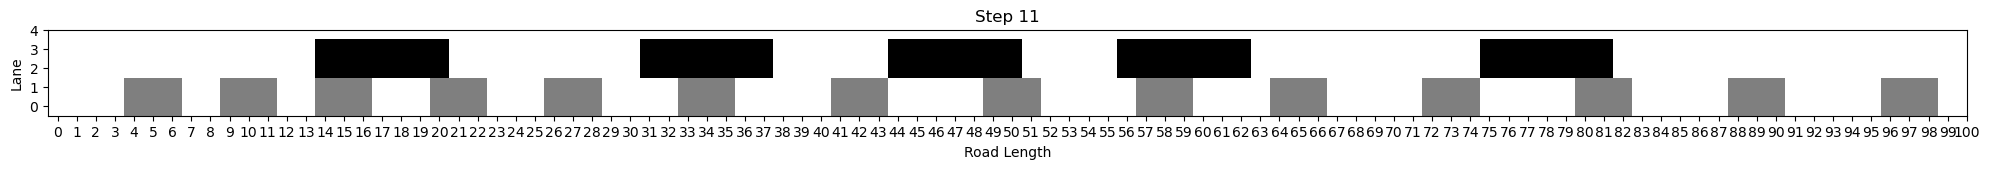

 jeep 137 attributes
ACCELERATE DEBUGGER: jeep 137 want to move at a speed of 3
jeep 137's rear bumper is at 9
jeep 137's front bumper is at 11
jeep 137's maximum distance is  3
jeep 137's road has length of 100
jeep 137: default gap distance is 3
jeep 137: At the current speed, we are checking position 12 row 0 to 1 
jeep 137: At the current speed, we check until position 14
Checking occupancy at position 12 in row 0 to row 1
[0. 0.]
jeep 137: At the current speed, we are checking position 13 row 0 to 1 
jeep 137: At the current speed, we check until position 14
Checking occupancy at position 13 in row 0 to row 1
[0. 0.]
jeep 137: At the current speed, we are checking position 14 row 0 to 1 
jeep 137: At the current speed, we check until position 14
Checking occupancy wrap-around at position 14 in row 0 to row 1
[1. 1.]
jeep 137 is decelerating on own lane
BEFORE MOVE DEBUGGER: jeep 137 is at position 9
AFTER MOVE DEBUGGER: jeep 137 is at position 11, with a speed of 2 at row 0
 jeep 

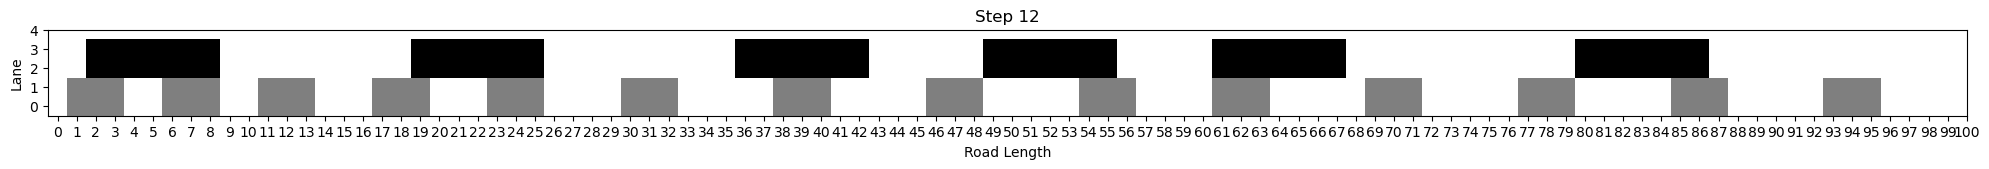

 truck 132 attributes
ACCELERATE DEBUGGER: truck 132 want to move at a speed of 5
truck 132's rear bumper is at 19
truck 132's front bumper is at 25
truck 132's maximum distance is  5
truck 132's road has length of 100
truck 132: default gap distance is 5
truck 132: At the current speed, we are checking position 26 row 2 to 3 
truck 132: At the current speed, we check until position 30
Checking occupancy at position 26 in row 2 to row 3
[0. 0.]
truck 132: At the current speed, we are checking position 27 row 2 to 3 
truck 132: At the current speed, we check until position 30
Checking occupancy at position 27 in row 2 to row 3
[0. 0.]
truck 132: At the current speed, we are checking position 28 row 2 to 3 
truck 132: At the current speed, we check until position 30
Checking occupancy at position 28 in row 2 to row 3
[0. 0.]
truck 132: At the current speed, we are checking position 29 row 2 to 3 
truck 132: At the current speed, we check until position 30
Checking occupancy at position 2

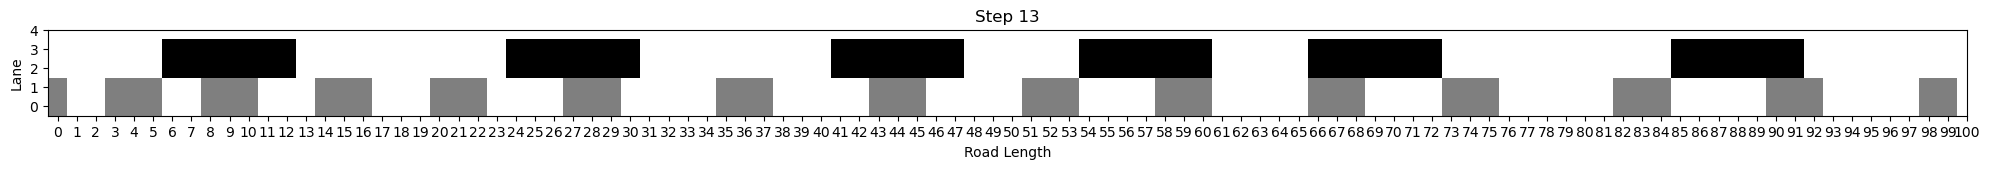

 jeep 123 attributes
ACCELERATE DEBUGGER: jeep 123 want to move at a speed of 5
jeep 123's rear bumper is at 82
jeep 123's front bumper is at 84
jeep 123's maximum distance is  5
jeep 123's road has length of 100
jeep 123: default gap distance is 5
jeep 123: At the current speed, we are checking position 85 row 0 to 1 
jeep 123: At the current speed, we check until position 89
Checking occupancy at position 85 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 86 row 0 to 1 
jeep 123: At the current speed, we check until position 89
Checking occupancy at position 86 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 87 row 0 to 1 
jeep 123: At the current speed, we check until position 89
Checking occupancy at position 87 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 88 row 0 to 1 
jeep 123: At the current speed, we check until position 89
Checking occupancy at position 88 in row 0 to r

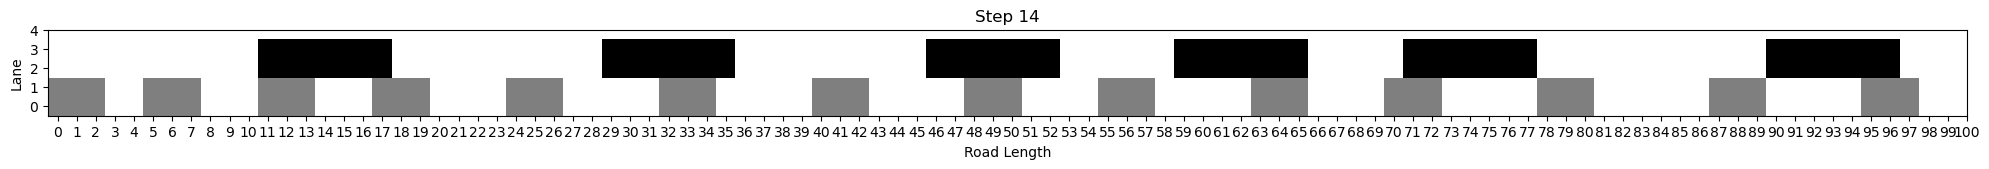

 jeep 142 attributes
ACCELERATE DEBUGGER: jeep 142 want to move at a speed of 5
jeep 142's rear bumper is at 24
jeep 142's front bumper is at 26
jeep 142's maximum distance is  5
jeep 142's road has length of 100
jeep 142: default gap distance is 5
jeep 142: At the current speed, we are checking position 27 row 0 to 1 
jeep 142: At the current speed, we check until position 31
Checking occupancy at position 27 in row 0 to row 1
[0. 0.]
jeep 142: At the current speed, we are checking position 28 row 0 to 1 
jeep 142: At the current speed, we check until position 31
Checking occupancy at position 28 in row 0 to row 1
[0. 0.]
jeep 142: At the current speed, we are checking position 29 row 0 to 1 
jeep 142: At the current speed, we check until position 31
Checking occupancy at position 29 in row 0 to row 1
[0. 0.]
jeep 142: At the current speed, we are checking position 30 row 0 to 1 
jeep 142: At the current speed, we check until position 31
Checking occupancy at position 30 in row 0 to r

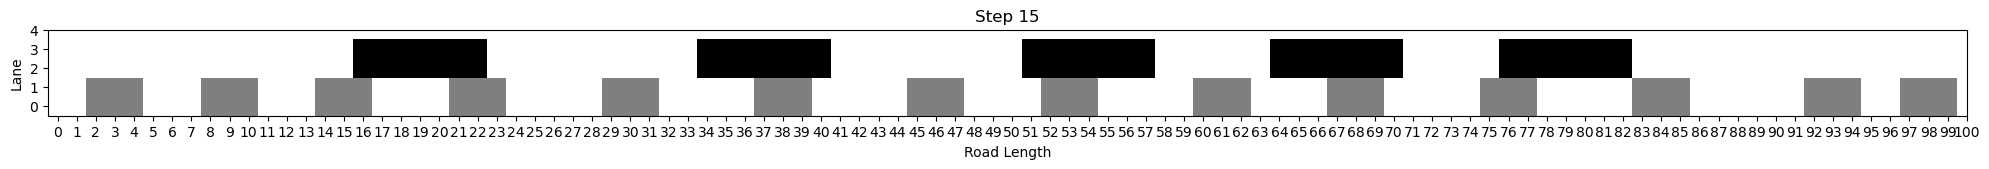

 truck 141 attributes
ACCELERATE DEBUGGER: truck 141 want to move at a speed of 5
truck 141's rear bumper is at 16
truck 141's front bumper is at 22
truck 141's maximum distance is  5
truck 141's road has length of 100
truck 141: default gap distance is 5
truck 141: At the current speed, we are checking position 23 row 2 to 3 
truck 141: At the current speed, we check until position 27
Checking occupancy at position 23 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 24 row 2 to 3 
truck 141: At the current speed, we check until position 27
Checking occupancy at position 24 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 25 row 2 to 3 
truck 141: At the current speed, we check until position 27
Checking occupancy at position 25 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 26 row 2 to 3 
truck 141: At the current speed, we check until position 27
Checking occupancy at position 2

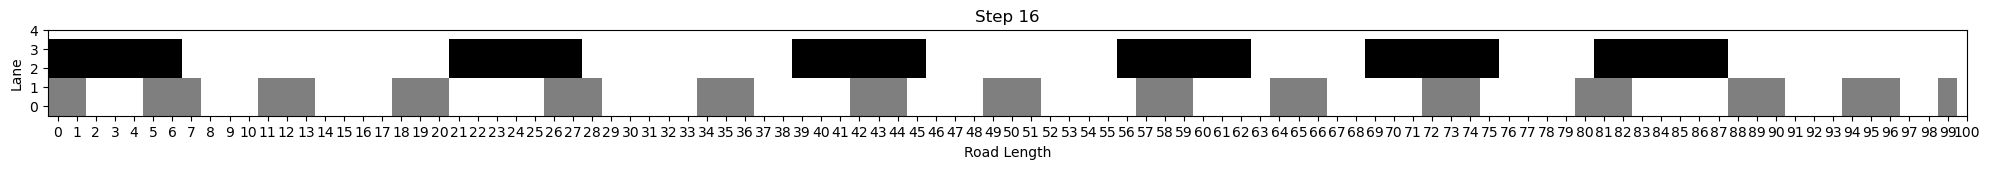

 truck 141 attributes
ACCELERATE DEBUGGER: truck 141 want to move at a speed of 5
truck 141's rear bumper is at 21
truck 141's front bumper is at 27
truck 141's maximum distance is  5
truck 141's road has length of 100
truck 141: default gap distance is 5
truck 141: At the current speed, we are checking position 28 row 2 to 3 
truck 141: At the current speed, we check until position 32
Checking occupancy at position 28 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 29 row 2 to 3 
truck 141: At the current speed, we check until position 32
Checking occupancy at position 29 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 30 row 2 to 3 
truck 141: At the current speed, we check until position 32
Checking occupancy at position 30 in row 2 to row 3
[0. 0.]
truck 141: At the current speed, we are checking position 31 row 2 to 3 
truck 141: At the current speed, we check until position 32
Checking occupancy at position 3

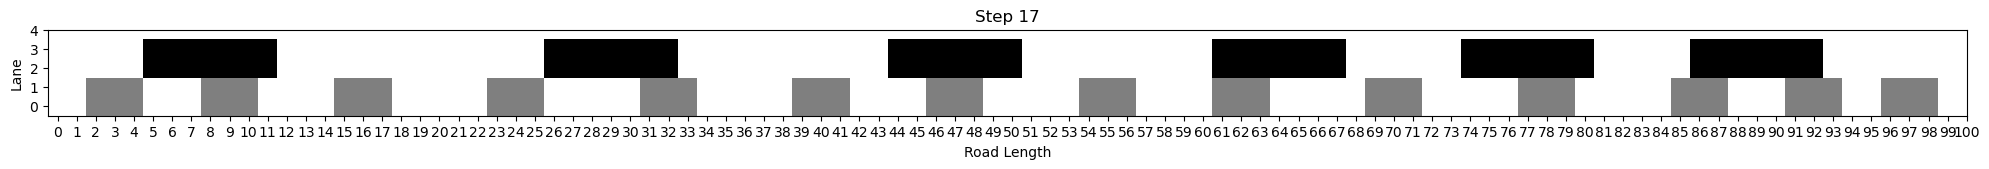

 jeep 123 attributes
ACCELERATE DEBUGGER: jeep 123 want to move at a speed of 3
jeep 123's rear bumper is at 96
jeep 123's front bumper is at 98
jeep 123's maximum distance is  3
jeep 123's road has length of 100
jeep 123: default gap distance is 3
jeep 123: At the current speed, we are checking position 99 row 0 to 1 
jeep 123: At the current speed, we check until position 1
Checking occupancy wrap-around at position 99 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 0 row 0 to 1 
jeep 123: At the current speed, we check until position 1
Checking occupancy at position 0 in row 0 to row 1
[0. 0.]
jeep 123: At the current speed, we are checking position 1 row 0 to 1 
jeep 123: At the current speed, we check until position 1
Checking occupancy wrap-around at position 1 in row 0 to row 1
[0. 0.]
BEFORE MOVE DEBUGGER: jeep 123 is at position 96
AFTER MOVE DEBUGGER: jeep 123 is at position 99, with a speed of 3 at row 0
 truck 130 attributes
ACCELERATE DEB

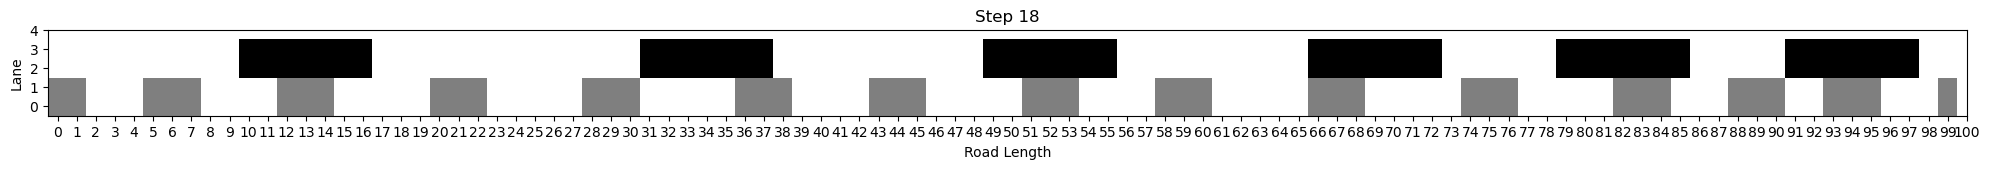

 jeep 125 attributes
ACCELERATE DEBUGGER: jeep 125 want to move at a speed of 3
jeep 125's rear bumper is at 93
jeep 125's front bumper is at 95
jeep 125's maximum distance is  3
jeep 125's road has length of 100
jeep 125: default gap distance is 3
jeep 125: At the current speed, we are checking position 96 row 0 to 1 
jeep 125: At the current speed, we check until position 98
Checking occupancy at position 96 in row 0 to row 1
[0. 0.]
jeep 125: At the current speed, we are checking position 97 row 0 to 1 
jeep 125: At the current speed, we check until position 98
Checking occupancy at position 97 in row 0 to row 1
[0. 0.]
jeep 125: At the current speed, we are checking position 98 row 0 to 1 
jeep 125: At the current speed, we check until position 98
Checking occupancy wrap-around at position 98 in row 0 to row 1
[0. 0.]
BEFORE MOVE DEBUGGER: jeep 125 is at position 93
AFTER MOVE DEBUGGER: jeep 125 is at position 96, with a speed of 3 at row 0
 jeep 127 attributes
ACCELERATE DEBUGGER:

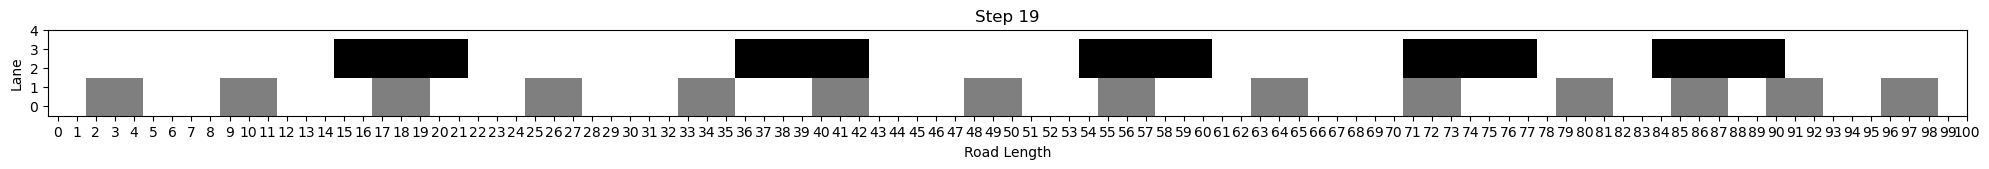

In [121]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 0.5  # Example density
truck_fraction = 0.3 # Example truck fraction
timesteps = 20
simulator.initialize_vehicles(density, truck_fraction, 0.3, 0)
for step in range(timesteps):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)

MOVING CHECKER

In [ ]:
def animate(step):
    simulator.simulation_step()  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Road Length')
    ax.set_ylabel('Lane')
    ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    ax.grid(True)

# Initialize road and simulator
road = Road(road_length=50, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 0.6
truck_fraction = 0.1

simulator.initialize_vehicles(density, truck_fraction, 1, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(20, 6))

# Create the animation
anim = FuncAnimation(fig, animate, frames=100, interval=900)

# Save the animation as a GIF or MP4
anim.save('road_simulation_vehicle_only(truck fraction = 0.1, density = 1).gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()

In [ ]:
# Define the density values you want to test
density_values = np.linspace(0, 1, 20)  # Example: 8 density points from 0.05 to 0.4
timesteps = 1000
truck_fraction = 0.3

# Create a directory to store the CSV files
output_dir = "density_timesteps_output2"
os.makedirs(output_dir, exist_ok=True)

for density in density_values:
    road = Road(road_length=200, road_width=4, speed_limit=5)
    simulator = IntraRoadSimulator(road)
    simulator.initialize_vehicles(density, truck_fraction, 1, 0)
    
    csv_filename = os.path.join(output_dir, f'density_{density:.2f}.csv')
    
    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Timestep", "Throughput"])
        
        for step in range(timesteps):
            simulator.simulation_step(density, truck_fraction)
            throughput_at_step = simulator.vehicle_throughput
            writer.writerow([step + 1, throughput_at_step])
            
    print(f'Saved: {csv_filename}')

print("CSV files for all densities and timesteps have been saved.")